Time-series forecasting from IoT Home Automation Data.

Tuomas Eerola - 2019

Data source: https://github.com/eerolat/home-automation-data-logger

# Run either of the following cells.

This will to connect you to the data:


1.   Some test data from the Internet; or
2.   the actual sensor data.


In [92]:
import pandas as pd

from urllib.request import urlopen

log_url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv"

url = urlopen(log_url)

series_example = pd.read_csv(log_url, header=0, index_col=0)

series = series_example

print ("Data loading ready.")

Data loading ready.


In [93]:
import pandas as pd

from urllib.request import urlopen

log_url = "http://eerola.dy.fi/temp/temperature.log"

series_own = pd.read_csv(log_url, sep=" ", parse_dates=[[0, 1]])
series_own.columns=['Date Time', 'SourceInfo1', 'SourceInfo2', 'MeasurementInfo1', 'Temp', 'MeasurementInfo2', 'Measurement2']
#series_own.insert(6, "Target", "NaN")
dropcolumns = ['SourceInfo1', 'SourceInfo2', 'MeasurementInfo1', 'MeasurementInfo2', 'Measurement2']
series_own.drop(dropcolumns, inplace=True, axis=1)
series_own.set_index('Date Time', inplace=True)

series = series_own

series = series_own.tail(1000)

series = series.resample('H').mean()

print ("Data loading ready.")

Data loading ready.


# Visualize the data to see what we've got.

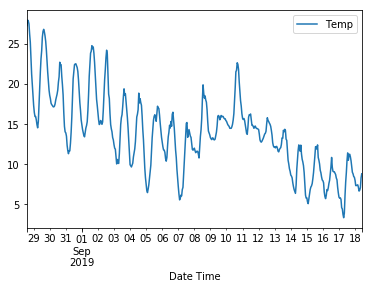

In [94]:
from matplotlib import pyplot


series.plot()
pyplot.show()

# Split the data into training and validation datasets.

In [0]:
#How many percent of the source data will be used as validation data

validation_part = 0

In [96]:
split_point = len(series) - (round(len(series) * validation_part))
dataset, validation = series[0:split_point], series[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))
dataset.to_csv('dataset.csv', index=False)
validation.to_csv('validation.csv', index=False)

Dataset 501, Validation 0


# Let's define some fuctions that we will use later.

In [97]:
import numpy

# create a differenced series
def difference(dataset, interval=1):
  diff = list()
  for i in range(interval, len(dataset)):
    if (i != 0 and i - interval != 0):
      value = float(dataset[i]) - float(dataset[i - interval])
      diff.append(value)
  return numpy.array(diff)

print("Ready.")

Ready.


In [98]:
import numpy

# create a differenced series
def difference_new(dataset, interval=1):
  diff = list()
  dataset = dataset[1:].astype(float)
  
  diff = (dataset - dataset.mean()).values
  
  return numpy.array(diff)

print("Ready.")

Ready.


In [99]:
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + float(history[-interval])

print("Ready.")

Ready.


# Let's run a forecast for the following 6 hours (12 time steps).

In [101]:
from pandas import read_csv
from statsmodels.tsa.arima_model import ARIMA

# load dataset
series = read_csv('dataset.csv', header=None)
# seasonal difference
X = series.values
#days_in_year = 365
samples_per_day = 24
differenced = difference(X, samples_per_day)
#differenced = difference_new(series)
# fit model
model = ARIMA(differenced, order=(12,0,1))
model_fit = model.fit(disp=0)
# multi-step out-of-sample forecast
start_index = len(differenced)
end_index = start_index + 11
forecast = model_fit.predict(start=start_index, end=end_index)
# invert the differenced forecast to something usable
history = [x for x in X]
measurement = 1 
for yhat in forecast:
	inverted = inverse_difference(history, yhat, samples_per_day)
	print('Measurement %d: %f' % (measurement, inverted))
	history.append(inverted)
	measurement += 1

Measurement 1: 9.287740
Measurement 2: 10.427636
Measurement 3: 11.115121
Measurement 4: 10.063774
Measurement 5: 10.744519
Measurement 6: 10.986548
Measurement 7: 10.726922
Measurement 8: 10.213507
Measurement 9: 9.464477
Measurement 10: 8.747854
Measurement 11: 8.559589
Measurement 12: 8.195727


# We can compare the forecast to current data.

In [45]:
print(dataset.tail(1))

                      Temp
Date Time                 
2019-09-14 05:00:00  6.845


In [9]:
print(validation.head(12))

                      Temp
Date Time                 
2019-09-14 06:00:04   6.56
2019-09-14 06:30:04   6.63
2019-09-14 07:00:04   6.56
2019-09-14 07:30:04   6.19
2019-09-14 08:00:03   6.63
2019-09-14 08:30:04   8.25
2019-09-14 09:00:04   9.13
2019-09-14 09:30:03   9.69
2019-09-14 10:00:04  10.25
2019-09-14 10:30:04  10.88
2019-09-14 11:00:05  11.50
2019-09-14 11:30:04  11.94
